In [ ]:
import os
import tensorflow as tf
import numpy as np #adds support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import pandas as pd #data structures and operations for manipulating numerical tables and time series
import sys # system path io
import glob #glob module is used to retrieve files/pathnames matching a specified pattern
from tqdm import tqdm # show progress bar when a loop is running
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from plotly import tools
from plotly.graph_objs import *
from plotly.graph_objs.layout import Margin, YAxis, XAxis
init_notebook_mode()
import matplotlib.pyplot as plt
from matplotlib import patches as patches
from pathlib import Path
import xml.etree.ElementTree as ET
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras import backend as K
import io
from google.colab import drive
from sklearn.model_selection import KFold, StratifiedKFold,LeaveOneOut
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras import backend as K
from keras.callbacks import EarlyStopping
import shutil
import statistics
from keras.models import Model
from tensorflow.keras import layers
drive.mount('/content/gdrive')


In [ ]:
!mkdir validation
!mkdir validation/reticulocyte
!mkdir validation/erythrocyte
!mkdir validation/BG

In [ ]:
!ls /content/gdrive/MyDrive/Alldata/BG  | wc -l
!ls /content/gdrive/MyDrive/Alldata/reticulocyte  | wc -l
!ls /content/gdrive/MyDrive/Alldata/erythrocyte  | wc -l
'''
479
470
1507
'''

ls: cannot access '/content/gdrive/MyDrive/Alldata/BG': No such file or directory
0
ls: cannot access '/content/gdrive/MyDrive/Alldata/reticulocyte': No such file or directory
0
ls: cannot access '/content/gdrive/MyDrive/Alldata/erythrocyte': No such file or directory
0


'\n479\n470\n1507\n'

In [ ]:
IMAGE_SIZE=[100,100]
batch_size=32
NN = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)  # do not include head, transfer learning
for layer in NN.layers:
    layer.trainable = False
# layers creation - Here more can be added
x = layers.Flatten()(NN.output)
x = layers.Dense(1000, activation='relu')(x)
prediction = layers.Dense(3, activation='softmax')(x)
# creating a model object
model = Model(inputs=NN.input, outputs=prediction)
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(
  loss='categorical_crossentropy',

  optimizer='sgd',

  metrics=['accuracy'] 

)

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
import PIL
X=[]
Y=[]
base_dir="/content/gdrive/MyDrive/Alldata"
labels_list=['erythrocyte','reticulocyte','BG']#retic_df["class"].unique().tolist()
dir=os.getcwd()
for directory in labels_list:
    print(directory)
    #print(len(os.listdir(base_dir+'/'+directory)))
    for files in os.listdir(base_dir+'/'+directory):
        #img = Image.open(directory+'/'+files)
        #img = img.convert('L')
        #img = img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
        X.append(directory+'/'+files)
        #X.append([np.array(img)])
        current_index=labels_list.index(directory)
        Y.append(current_index)
X=np.asarray(X)
Y=np.asarray(Y)

erythrocyte
reticulocyte
BG


In [ ]:
#kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
cvscores = []

validation_path="validation"
train_path= '/content/gdrive/MyDrive/Alldata/'
#skf = StratifiedKFold(n_splits=2, shuffle=True)
#skf.get_n_splits(X, Y)
accuracy_list= list()
precision_list=list()
f1_list=list()
microprecision_list=list()
microf1_list=list()
means, mins, maxs = list(),list(),list()
f1means, f1mins, f1maxs = list(),list(),list()
microf1means, microf1mins, microf1maxs = list(),list(),list()
precmeans, precmins, precmaxs = list(),list(),list()
microprecmeans, microprecmins, microprecmaxs = list(),list(),list()

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,min_delta=.001,mode='auto')
foldNum=0
k=5
skf = StratifiedKFold(n_splits=k, shuffle=True)

for train_index, val_index in skf.split(X, Y):
             
       foldNum+=1
       model.compile(loss='categorical_crossentropy', optimizer='sgd',  metrics=['accuracy'] )
       print("Results for fold",foldNum)
       X_train, X_val = X[train_index], X[val_index]
       Y_train, Y_val = Y[train_index], Y[val_index]
       for eachindex in range(len(X_val)):
           shutil.move('/content/gdrive/MyDrive/Alldata/'+X_val[eachindex], 
                    'validation/'+X_val[eachindex])
       
       #Start ImageClassification Model
       train_datagen = ImageDataGenerator(rotation_range=20, horizontal_flip=True,   vertical_flip=True,  preprocessing_function=preprocess_input)

       validation_datagen = ImageDataGenerator( preprocessing_function=preprocess_input)
       train_generator = train_datagen.flow_from_directory(
            train_path,
            shuffle= True,
            target_size=IMAGE_SIZE,
            batch_size=32,
            subset='training')
       validation_generator = validation_datagen.flow_from_directory(
            validation_path,
            target_size=IMAGE_SIZE,
            batch_size=32,
            shuffle=False)  
       
       #history=
       model.fit(train_generator, 
                        epochs=40,
                        validation_data = validation_generator,
                        steps_per_epoch=int(len(X_train) // batch_size),
                        validation_steps=int(len(X_val) // batch_size),
                        callbacks=[callback])
       predictions = model.predict(validation_generator, verbose=1)
       #score = model.evaluate(validation_generator,batch_size =32)
       #print('eval', score)
       yPredictions = np.argmax(predictions, axis=1)
       true_classes = validation_generator.classes
       # evaluate validation performance
       #print("***Performance on Validation data***")
       accuracy=accuracy_score(true_classes, yPredictions)
       f1=f1_score(true_classes, yPredictions,average='macro')
       microf1= f1_score(true_classes, yPredictions,average='micro')
       precision= precision_score(true_classes, yPredictions,average='macro')
       microprecision= precision_score(true_classes, yPredictions,average='micro')
       #precision=precision_score(true_classes, yPredictions,average='weighted')
       #f1Score=f1_score(true_classes, yPredictions, average='weighted') 
       #print("Accuracy  : {}".format(accuracy))
       #print("Precision : {}".format(precision))
       #print("f1Score : {}".format(f1Score))
       #cm=confusion_matrix(true_classes, yPredictions)
       accuracy_list.append(accuracy)
       f1_list.append(f1)
       precision_list.append(precision)
       microf1_list.append(microf1)
       microprecision_list.append(microprecision)
       #print(cm)
       #valAcc, valPrec, valFScore = my_metrics(true_classes, yPredictions)
       for returnindex in range(len(X_val)):
            shutil.move('validation/'+X_val[returnindex],'/content/gdrive/MyDrive/Alldata/'+X_val[returnindex])
#gotta change this to F1
k_mean=statistics.mean(accuracy_list)
k_max=max(accuracy_list)
k_min=min(accuracy_list)
means.append(k_mean)
mins.append(k_mean - k_min)
maxs.append(k_max - k_mean)
#==================
f1_mean=statistics.mean(f1_list)
f1_max=max(f1_list)
f1_min=min(f1_list)
f1means.append(f1_mean)
f1mins.append(f1_mean - f1_min)
f1maxs.append(f1_max - f1_mean)
#========================
prec_mean=statistics.mean(precision_list)
prec_max=max(precision_list)
prec_min=min(precision_list)
precmeans.append(prec_mean)
precmins.append(prec_mean - prec_min)
precmaxs.append(prec_max - prec_mean)
#==========================
microprec_mean=statistics.mean(microprecision_list)
microprec_max=max(microprecision_list)
microprec_min=min(microprecision_list)
microprecmeans.append(microprec_mean)
microprecmins.append(microprec_mean - microprec_min)
microprecmaxs.append(microprec_max - microprec_mean)
#===========================
microf1_mean=statistics.mean(microf1_list)
microf1_max=max(microf1_list)
microf1_min=min(microf1_list)
microf1means.append(microf1_mean)
microf1mins.append(microf1_mean - microf1_min)
microf1maxs.append(microf1_max - microf1_mean)

print('Image_size and batch_size')
print(IMAGE_SIZE,batch_size)
print('Minimum Accuracy')
print(mins)
print('Maximum Accuracy')
print(maxs)
print('Average Accuracy')
print(means)
#=============
print('Minimum macro precision')
print(precmins)
print('Maximum macro precision')
print(precmaxs)
print('Average macro precision')
print(precmeans)
#===============
print('Minimum macro F1')
print(f1mins)
print('Maximum macro F1')
print(f1maxs)
print('Average macro F1')
print(f1means)
#===============
print('Minimum micro precision')
print(microprecmins)
print('Maximum micro precision')
print(microprecmaxs)
print('Average micro precision')
print(microprecmeans)
#===============
print('Minimum micro F1')
print(microf1mins)
print('Maximum micro F1')
print(microf1maxs)
print('Average micro F1')
print(microf1means)
#plt.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
# plot the ideal case in a separate color
#plt.plot(folds, [ideal for _ in range(len(folds))], color='r')
# show the plot
#plt.show()
   #model.fit_generator(train_generator, epochs=50,  verbose = 0, validation_data=test_generator)

   #scores = model.evaluate(X[test], Y[test], verbose=0)
   #print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))




Results for fold 1
Found 1964 images belonging to 3 classes.
Found 492 images belonging to 3 classes.
Epoch 1/40
61/61 [==============================] - 1381s 22s/step - loss: 6.8364 - accuracy: 0.8188 - val_loss: 0.1409 - val_accuracy: 0.9563
Epoch 2/40
61/61 [==============================] - 12s 199ms/step - loss: 0.1099 - accuracy: 0.9565 - val_loss: 0.1170 - val_accuracy: 0.9688
Epoch 3/40
61/61 [==============================] - 12s 198ms/step - loss: 0.1090 - accuracy: 0.9640 - val_loss: 0.0756 - val_accuracy: 0.9771
Epoch 4/40
61/61 [==============================] - 12s 201ms/step - loss: 0.0589 - accuracy: 0.9797 - val_loss: 0.0606 - val_accuracy: 0.9812
Epoch 5/40
61/61 [==============================] - 12s 197ms/step - loss: 0.0627 - accuracy: 0.9824 - val_loss: 0.0755 - val_accuracy: 0.9792
Epoch 6/40
61/61 [==============================] - 12s 199ms/step - loss: 0.0309 - accuracy: 0.9880 - val_loss: 0.0750 - val_accuracy: 0.9812
Epoch 7/40
16/16 [======================

In [ ]:
####retrain on the entire dataset
IMAGE_SIZE=[100,100]
entire_datasetNN = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)  # do not include head, transfer learning
for layer in entire_datasetNN.layers:
    layer.trainable = False
# layers creation - Here more can be added
xlayers = layers.Flatten()(entire_datasetNN.output)
xlayers = layers.Dense(1000, activation='relu')(xlayers)
Alldataprediction = layers.Dense(3, activation='softmax')(xlayers)
# creating a model object
alldatamodel = Model(inputs=entire_datasetNN.input, outputs=Alldataprediction)
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
alldatamodel.compile(
  loss='categorical_crossentropy',

  optimizer='sgd',

  metrics=['accuracy'] 

)


In [ ]:
Alldatatrain_path= '/content/gdrive/MyDrive/Alldata'
Alldatavalidation_path= '/content/gdrive/MyDrive/Alldata'
batch_size=32
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=.001,patience=3,mode='auto')
alldatatrain_datagen = ImageDataGenerator(rotation_range=20, horizontal_flip=True,   vertical_flip=True,  preprocessing_function=preprocess_input)
#,  width_shift_range=0.2, height_shift_range=0.2,brightness_range=[0.4,1.5],zoom_range=0.3
#
alldatavalidation_datagen = ImageDataGenerator( preprocessing_function=preprocess_input)
#Start ImageClassification Model
alldatatrain_generator = alldatatrain_datagen.flow_from_directory(
            Alldatatrain_path,
            shuffle= True,
            target_size=IMAGE_SIZE,
            batch_size=32)
alldatavalidation_generator = alldatavalidation_datagen.flow_from_directory(
            Alldatavalidation_path,
            target_size=IMAGE_SIZE,
            batch_size=32,
            shuffle=False)  
       
history=alldatamodel.fit(alldatatrain_generator, 
                        epochs=40,                       
                        validation_data = alldatavalidation_generator,
                        steps_per_epoch=int(2461 // batch_size),
                        validation_steps=int(2461 // batch_size),    
                        callbacks=[callback])

Found 2461 images belonging to 3 classes.
Found 2461 images belonging to 3 classes.
Epoch 1/40
76/76 [==============================] - 1115s 15s/step - loss: 10.5369 - accuracy: 0.8268 - val_loss: 0.1105 - val_accuracy: 0.9700
Epoch 2/40
76/76 [==============================] - 26s 340ms/step - loss: 0.1150 - accuracy: 0.9674 - val_loss: 0.0782 - val_accuracy: 0.9741
Epoch 3/40
76/76 [==============================] - 25s 336ms/step - loss: 0.0761 - accuracy: 0.9747 - val_loss: 0.0708 - val_accuracy: 0.9720
Epoch 4/40
76/76 [==============================] - 25s 334ms/step - loss: 0.0664 - accuracy: 0.9775 - val_loss: 0.0592 - val_accuracy: 0.9778
Epoch 5/40
76/76 [==============================] - 25s 335ms/step - loss: 0.0454 - accuracy: 0.9856 - val_loss: 0.0371 - val_accuracy: 0.9868
Epoch 6/40
76/76 [==============================] - 25s 337ms/step - loss: 0.0404 - accuracy: 0.9841 - val_loss: 0.0385 - val_accuracy: 0.9868
Epoch 7/40
76/76 [==============================] - 26s 3

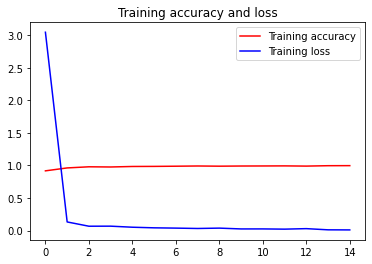

<Figure size 432x288 with 0 Axes>

In [ ]:
###save the model 
###plot the graphs

entire_datasetNN.save('ImagenetFreezingAlldata.h5')
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, loss, 'b', label='Training loss')
plt.title('Training accuracy and loss')
plt.legend(loc=0)
plt.figure()


plt.show()

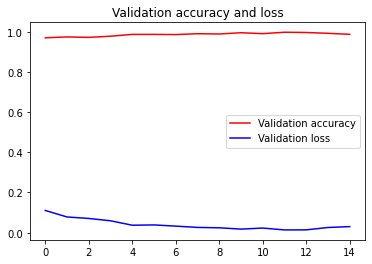

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Validation accuracy and loss')
plt.legend(loc=0)
plt.figure()


plt.show()

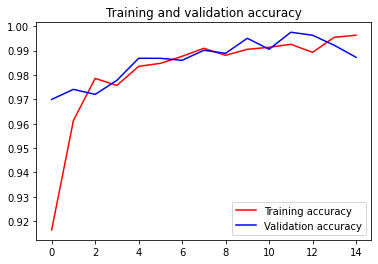

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

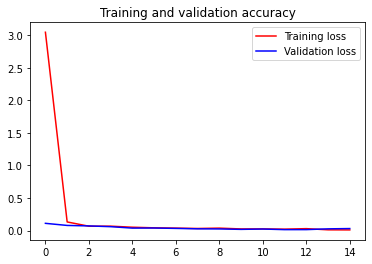

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
###get all the metrics 
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix
alldatapredictions = alldatamodel.predict(alldatavalidation_generator, verbose=1)
alldatayPredictions = np.argmax(alldatapredictions, axis=1)
alldatatrue_classes = alldatavalidation_generator.classes

77/77 [==============================] - 10s 130ms/step


In [ ]:
alldataaccuracy= accuracy_score(alldatatrue_classes, alldatayPredictions)
Macroalldataf1=f1_score(alldatatrue_classes, alldatayPredictions,average='macro')
Microalldataf1=f1_score(alldatatrue_classes, alldatayPredictions,average='micro')
Macroalldataprecision=precision_score(alldatatrue_classes, alldatayPredictions,average='macro')
Microalldataprecision=precision_score(alldatatrue_classes, alldatayPredictions,average='micro')
print('Accuracy' ,alldataaccuracy)
print('Macro f1' ,Macroalldataf1)
print('Micro f1' ,Microalldataf1)
print('Macro precision' ,Macroalldataprecision)
print('Micro precision' ,Microalldataprecision)
alldataCM= confusion_matrix(alldatatrue_classes, alldatayPredictions)
print(alldataCM)

Accuracy 0.9865908167411621
Macro f1 0.9844221184037578
Micro f1 0.9865908167411621
Macro precision 0.9928571428571429
Micro precision 0.9865908167411621
[[ 478    1    0]
 [   0 1507    0]
 [   0   32  443]]
